In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ujipenchars2
import string
from preprocessing import DrawingToBoxScaler, VideoCreator, GradientCreator, create_gradient
from hosvdclassifier import HOSVDClassifier
from classifier_pickle import HOSVDPickle

# Klasifikacija znamenki HOSVD-om koristeći reprezentaciju pomoću gradijenta

In [2]:
train, test = ujipenchars2.Parser('data/ujipenchars2').parse(string.digits)
data = train + test
train_idx = np.array(range(len(train)))
test_idx = np.array(range(len(train), len(data)))
labels = np.array([drawing.label for drawing in data])

len(train), len(test)

(800, 400)

In [3]:
# Preprocessing
drawing_scaler = DrawingToBoxScaler(0, 1, 0, 1)
data = drawing_scaler.transform(data)

# Izrada gradijenata
gradient_creator = GradientCreator(
    gradients = [
        create_gradient([(0, 0), (1, 255)], 100), # bijela -> crna
        create_gradient([(0, 255), (1, 0)], 100), # crna -> bijela
        create_gradient([(0, 0), (0.5, 255), (1, 0)], 100), # bijela -> crna -> bijela
    ],
    clip=(-0.15, 1.15, -0.15, 1.15),
    size=(20, 20),
    blur_radius=1,
)
gradients = gradient_creator.transform(data)

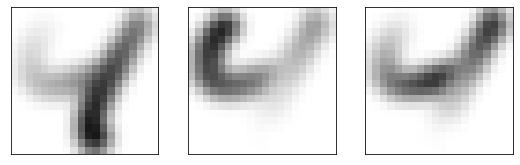

In [4]:
def plot_images(images: np.ndarray):
    n = len(images)
    plt.figure(figsize=(3*n, 3))

    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap="binary", vmin=0, vmax=255)
        axes = plt.gca().axes
        axes.xaxis.set_ticks([])
        axes.yaxis.set_ticks([])

    plt.show()

plot_images(gradient_creator.transform_one(data[8]))

In [5]:
%%time
cls = HOSVDClassifier([400]*4)
cls.fit(gradients[train_idx], labels[train_idx])
cls.score(gradients[test_idx], labels[test_idx])

CPU times: user 15.1 s, sys: 37.8 s, total: 52.9 s
Wall time: 3.64 s


0.9825

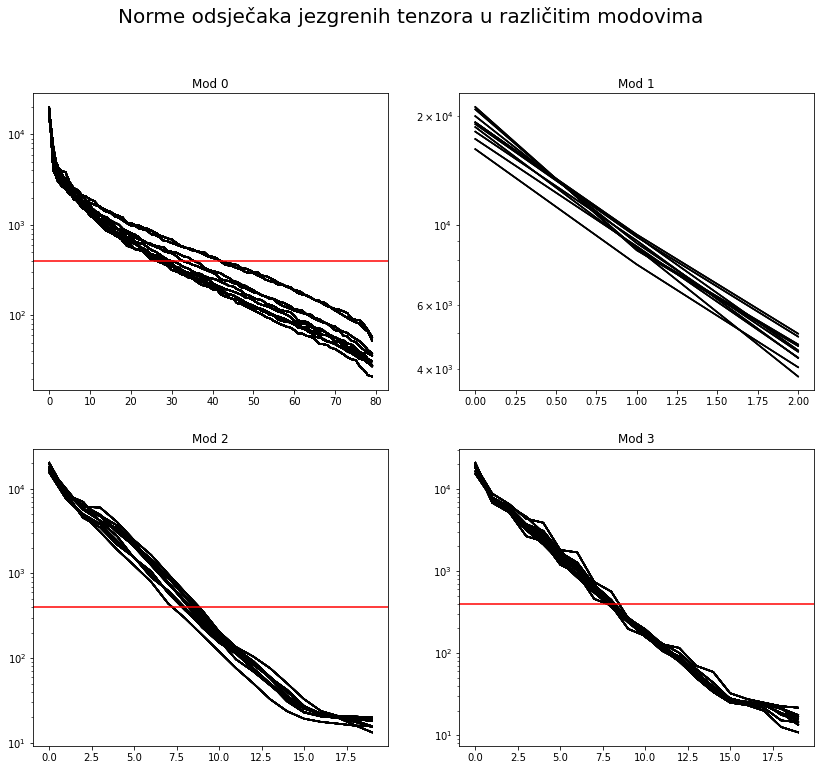

In [6]:
cls.plot_cuts()

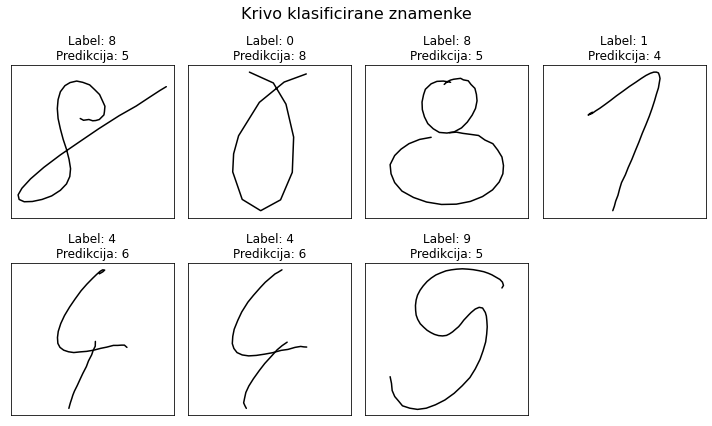

In [7]:
# Krivo klasificirane znamenke
p = cls.predict(gradients[test_idx])
wrong_idx = np.where(p != labels[test_idx])[0]
n = wrong_idx.shape[0]
rows = (n + 3) // 4
plt.figure(figsize=(10, rows * 3))
plt.suptitle('Krivo klasificirane znamenke', fontsize=16)
for i, idx in enumerate(wrong_idx):
    plt.subplot(rows, 4, i + 1)
    plt.title(f'Label: {labels[test_idx][idx]}\nPredikcija: {p[idx]}')
    for stroke in test[idx].strokes:
        plt.plot(stroke[:,0], stroke[:,1], color='black', solid_capstyle='round')
    axes = plt.gca().axes
    axes.xaxis.set_ticks([])
    axes.yaxis.set_ticks([])
    plt.axis('equal')
plt.tight_layout()

In [8]:
# Spremimo HOSVD model:
HOSVDPickle(
    transformers=[drawing_scaler, gradient_creator],
    cls=cls
).save('models/HOSVD-Gradient.pickle')

# Klasifikacija velikih slova engleske abecede

In [9]:
train, test = ujipenchars2.Parser('data/ujipenchars2').parse(string.ascii_uppercase)
data = train + test
train_idx = np.array(range(len(train)))
test_idx = np.array(range(len(train), len(data)))
labels = np.array([drawing.label for drawing in data])

len(train), len(test)

(2080, 1040)

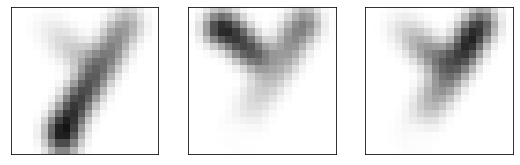

In [10]:
drawing_scaler = DrawingToBoxScaler(0, 1, 0, 1)
data = drawing_scaler.transform(data)

gradients = gradient_creator.transform(data)

plot_images(gradient_creator.transform_one(data[100]))

In [11]:
cls = HOSVDClassifier([1040]*4)
cls.fit(gradients[train_idx], labels[train_idx])
cls.score(gradients[test_idx], labels[test_idx])

0.8884615384615384

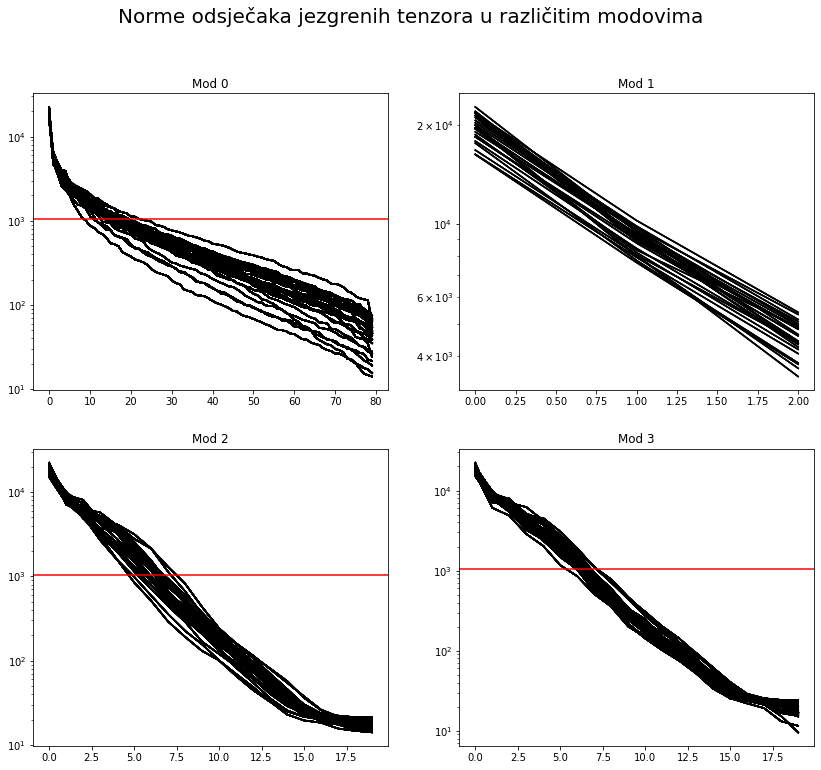

In [12]:
cls.plot_cuts()